In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import random

2023-05-19 08:48:54.093422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor(-881.8639, shape=(), dtype=float32)


In [2]:
df = pd.read_csv(os.getcwd()+'/imputed_urban_wisconsin_mobility_data_with_counts.csv')
date_time = pd.to_datetime(df.pop('date'), format='%Y.%m.%d')
mask = df['infection_count'] > 0
idx = df.loc[mask].index.values
diff = np.array(df.iloc[idx]['infection_count'])-np.array(df.iloc[idx-1]['infection_count'])
df.loc[idx, 'infection_count'] = diff

In [3]:
counties = list(set(df["sub_region_2"].tolist()))
random.shuffle(counties)
print(counties)

['Outagamie County', 'Waukesha County', 'St. Croix County', 'Brown County', 'Racine County', 'Dane County', 'Rock County', 'Washington County', 'Portage County', 'Wood County', 'Milwaukee County', 'Sheboygan County', 'Winnebago County', 'Dodge County', 'Kenosha County', 'Manitowoc County', 'Jefferson County', 'Marathon County', 'Eau Claire County', 'La Crosse County', 'Walworth County', 'Sauk County', 'Fond du Lac County']


In [4]:
train_df = df[df["sub_region_2"].isin(counties[0:16])]
val_df = df[df["sub_region_2"].isin(counties[16:20])]
test_df = df[df["sub_region_2"].isin(counties[20:23])]

In [5]:
# If we want to standarize the data
#train_mean = train_df.drop(['sub_region_2'], axis=1).mean()
#train_std = train_df.drop(['sub_region_2'], axis=1).std()

#train_df.update((train_df.loc[:, ~train_df.columns.isin(["sub_region_2"])] - train_mean) / train_std)
#val_df.update((val_df.loc[:, ~val_df.columns.isin(["sub_region_2"])] - train_mean) / train_std)
#test_df.update((test_df.loc[:, ~test_df.columns.isin(["sub_region_2"])] - train_mean) / train_std)


In [6]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.drop(["sub_region_2"], axis=1).columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [7]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [8]:
def plot(self, model=None, plot_col='infection_count', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel('new_infections')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [day]')

WindowGenerator.plot = plot

In [9]:
def make_dataset(self, data):
  #data = np.array(data, dtype=np.float32)
  ds_counties = list(set(data["sub_region_2"].tolist()))
  ds = tf.data.Dataset.from_tensor_slices([0.0])
  for county in ds_counties:
      county_data = np.array(data[data["sub_region_2"] == county].drop(["sub_region_2"], axis=1), dtype=np.float32)
      county_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=county_data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)
      ds = ds.concatenate(county_ds)
  ds = ds.skip(1)
  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [10]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [11]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [12]:
val_performance = {}
performance = {}

In [13]:
CONV_WIDTH = 7
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['infection_count'])

conv_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['infection_count']

In [14]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['infection_count'])

wide_conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
Label column name(s): ['infection_count']

In [15]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=16,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [16]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 7, 5)
Output shape: (32, 1, 1)


In [17]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 30, 5)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [18]:
wide_conv_window.example[1].shape

TensorShape([32, 24, 1])

In [19]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

36/36 [==============================] - 0s 3ms/step - loss: 579.0356 - mean_absolute_error: 10.3204


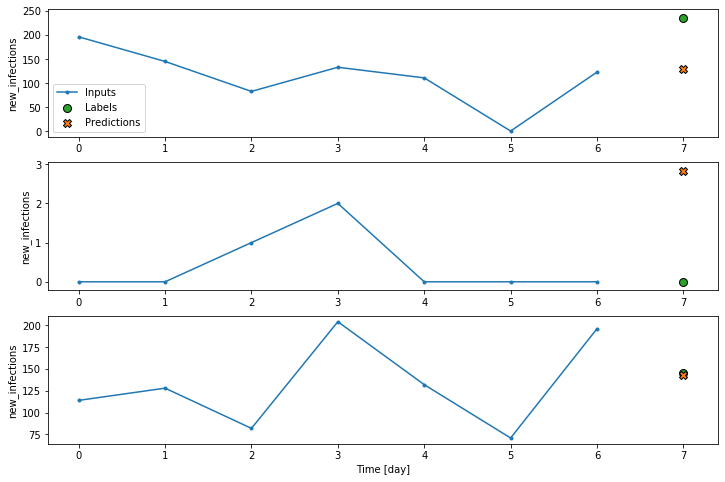

In [20]:
conv_window.plot(conv_model)

In [21]:
history = compile_and_fit(conv_model, wide_conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(wide_conv_window.val)
performance['Conv'] = conv_model.evaluate(wide_conv_window.test, verbose=0)

32/32 [==============================] - 0s 3ms/step - loss: 424.3176 - mean_absolute_error: 9.9829


In [22]:
val_performance['Conv']

[424.317626953125, 9.98293685913086]

In [23]:
performance['Conv']

[417.958984375, 10.638213157653809]

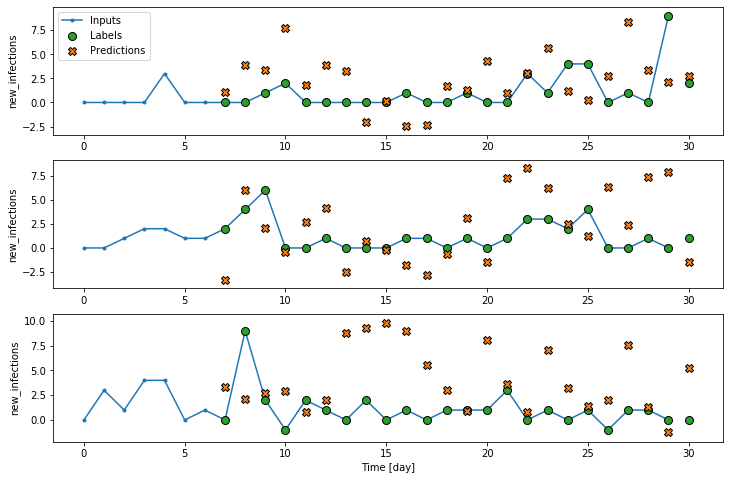

In [24]:
wide_conv_window.plot(conv_model)

In [25]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [26]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['infection_count'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['infection_count']

In [27]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


In [28]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

32/32 [==============================] - 0s 6ms/step - loss: 859.2180 - mean_absolute_error: 11.4972


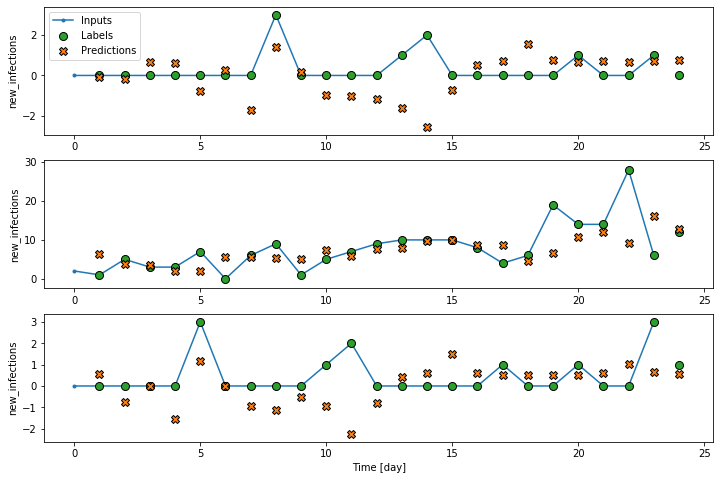

In [29]:
wide_window.plot(lstm_model)

In [31]:
val_performance['LSTM']

[859.218017578125, 11.497231483459473]

In [32]:
performance['LSTM']

[611.2603759765625, 10.188036918640137]

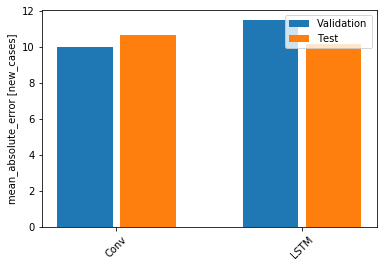

In [30]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [new_cases]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()